# Unweighted Max-Cut with Grover's Algorithm

## Setup

### Dependencies

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_distribution
import rustworkx as rx
from rustworkx.visualization import mpl_draw
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import math

### Settings

In [2]:
NUM_VERTICES = 6
NUM_EDGES = 12
EDGES = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4)]

# Number of edges we are searching for
SEARCH_NUM = 9

SHOTS = 10000

# Set to True to use noisy backend
NOISY_SIMULATOR = False

In [3]:
# Number qubits to use for summing cut edges
SUM_QUBITS = math.ceil(math.log2(NUM_EDGES + 1))

# Get search num in binary form
SEARCH = list(format(SEARCH_NUM, f'0{SUM_QUBITS}b'))
for (i, v) in enumerate(SEARCH):
    SEARCH[i] = int(v)

# Total number of qubits used
NUM_QUBITS = NUM_VERTICES + NUM_EDGES + SUM_QUBITS + 1

# Iterations of Grover's
GROVER_ITERATIONS = math.floor((math.pi / 4) * math.sqrt(2 ** NUM_VERTICES))

In [4]:
# Setup backend
backend = None
if NOISY_SIMULATOR:
    backend = FakeCairoV2()
    backend = AerSimulator.from_backend(backend)
    backend.set_options(shots=SHOTS)
else:
    backend = AerSimulator()
    backend.set_options(shots=SHOTS)

## Input Graph

### Create Graph

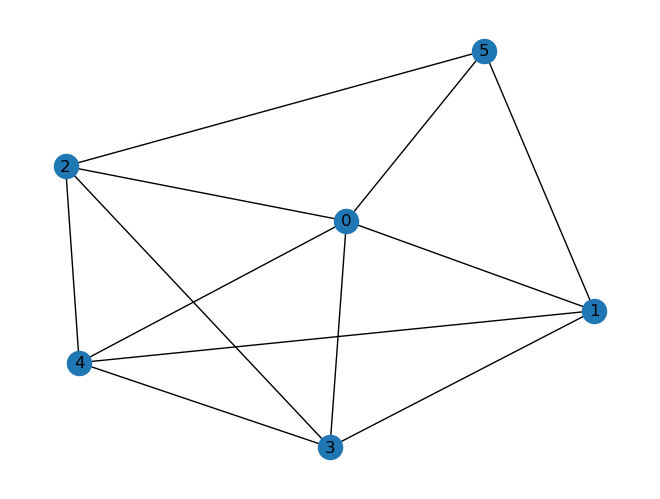

In [5]:
# Create input graph
V = [i for i in range(0, NUM_VERTICES)]
E = EDGES

# Draw input graph
G_draw = rx.PyGraph()
G_draw.add_nodes_from(V)
G_draw.add_edges_from([(i, j, 1) for (i, j) in E])

mpl_draw(
    G_draw,
    with_labels=True,
    labels=lambda x: V[x]
)

In [16]:
for k in range (1,5):
    print(k)

1
2
3
4


## Oracle

C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:164: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\styles\iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


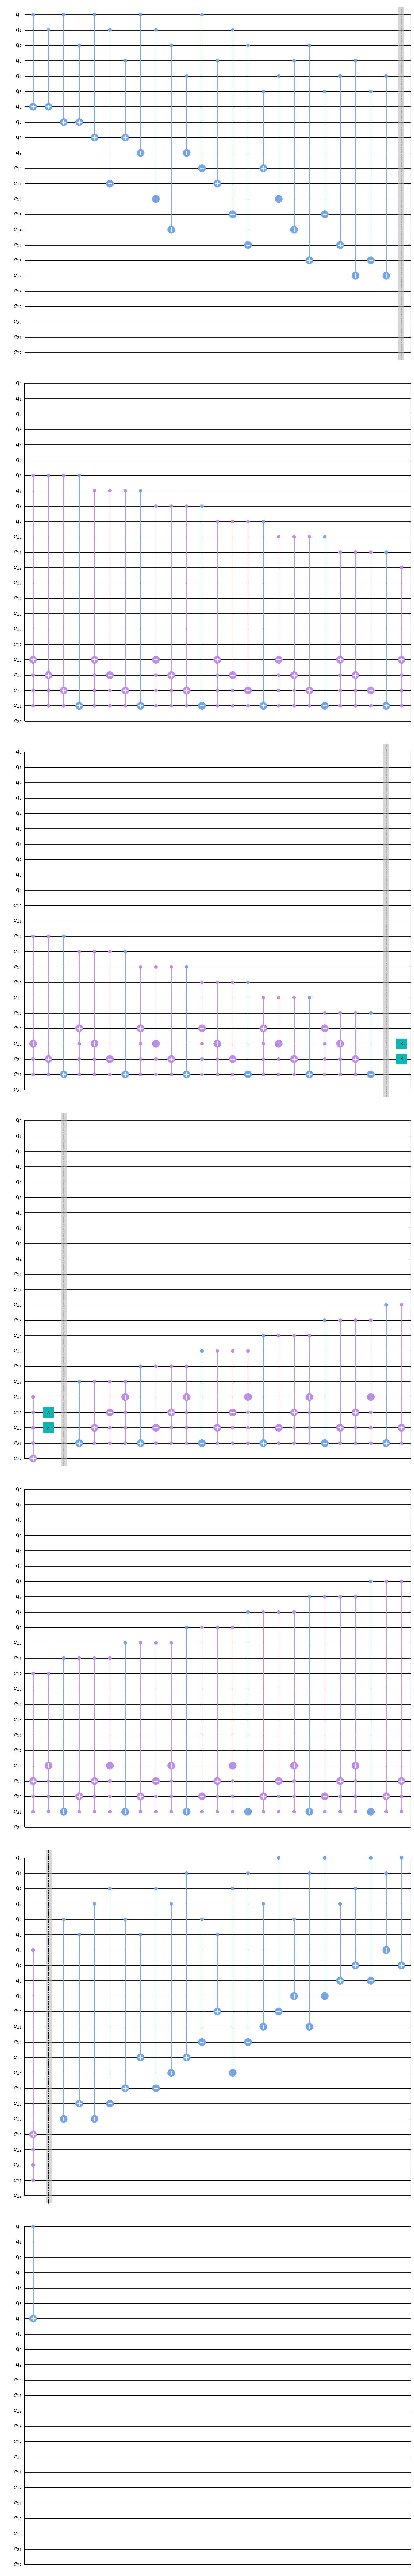

In [6]:
# ----- Create Oracle -----

oracle = QuantumCircuit(NUM_QUBITS, name="Oracle")

for i, e in enumerate(EDGES):
    oracle.cx(e[0], NUM_VERTICES + i)
    oracle.cx(e[1], NUM_VERTICES + i)

oracle.barrier()

for i, e in enumerate(EDGES):
    for k in range(1, SUM_QUBITS):
        controls = list(range(NUM_VERTICES + NUM_EDGES + k, NUM_VERTICES + NUM_EDGES + SUM_QUBITS))
        controls.append(NUM_VERTICES + i)
        oracle.mcx(controls, NUM_VERTICES + NUM_EDGES + k - 1)
    oracle.cx(NUM_VERTICES + i, NUM_VERTICES + NUM_EDGES + SUM_QUBITS - 1)

oracle.barrier()

for i, v in enumerate(SEARCH):
    if v == 0:
        oracle.x(NUM_VERTICES + NUM_EDGES + i)

oracle.mcx(list(range(NUM_VERTICES + NUM_EDGES, NUM_VERTICES + NUM_EDGES + SUM_QUBITS)), NUM_VERTICES + NUM_EDGES + SUM_QUBITS)

for i, v in enumerate(SEARCH):
    if v == 0:
        oracle.x(NUM_VERTICES + NUM_EDGES + i)

oracle.barrier()

for i, e in list(enumerate(EDGES))[::-1]:
    oracle.cx(NUM_VERTICES + i, NUM_VERTICES + NUM_EDGES + SUM_QUBITS - 1)
    for k in list(range(1, SUM_QUBITS))[::-1]:
        controls = list(range(NUM_VERTICES + NUM_EDGES + k, NUM_VERTICES + NUM_EDGES + SUM_QUBITS))
        controls.append(NUM_VERTICES + i)
        oracle.mcx(controls, NUM_VERTICES + NUM_EDGES + k - 1)

oracle.barrier()

for i, e in list(enumerate(EDGES))[::-1]:
    oracle.cx(e[1], NUM_VERTICES + i)
    oracle.cx(e[0], NUM_VERTICES + i)

oracle.draw(output='mpl', style='iqp')

## Grover Diffusion Operator

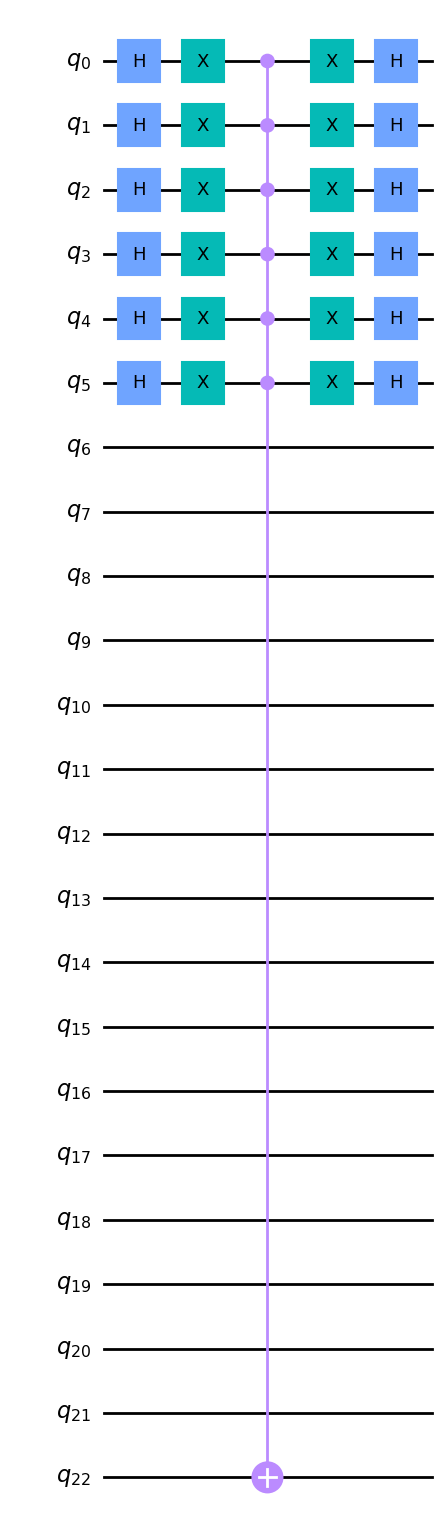

In [7]:
# ----- Create Grover Diffusion Operator -----

diffuser = QuantumCircuit(NUM_QUBITS, name="Diffuser")

for i in range(0, NUM_VERTICES):
    diffuser.h(i)
    diffuser.x(i)

diffuser.mcx(list(range(0, NUM_VERTICES)), NUM_VERTICES + NUM_EDGES + SUM_QUBITS)

for i in range(0, NUM_VERTICES):
    diffuser.x(i)
    diffuser.h(i)

diffuser.draw(output='mpl', style='iqp')

## Circuit

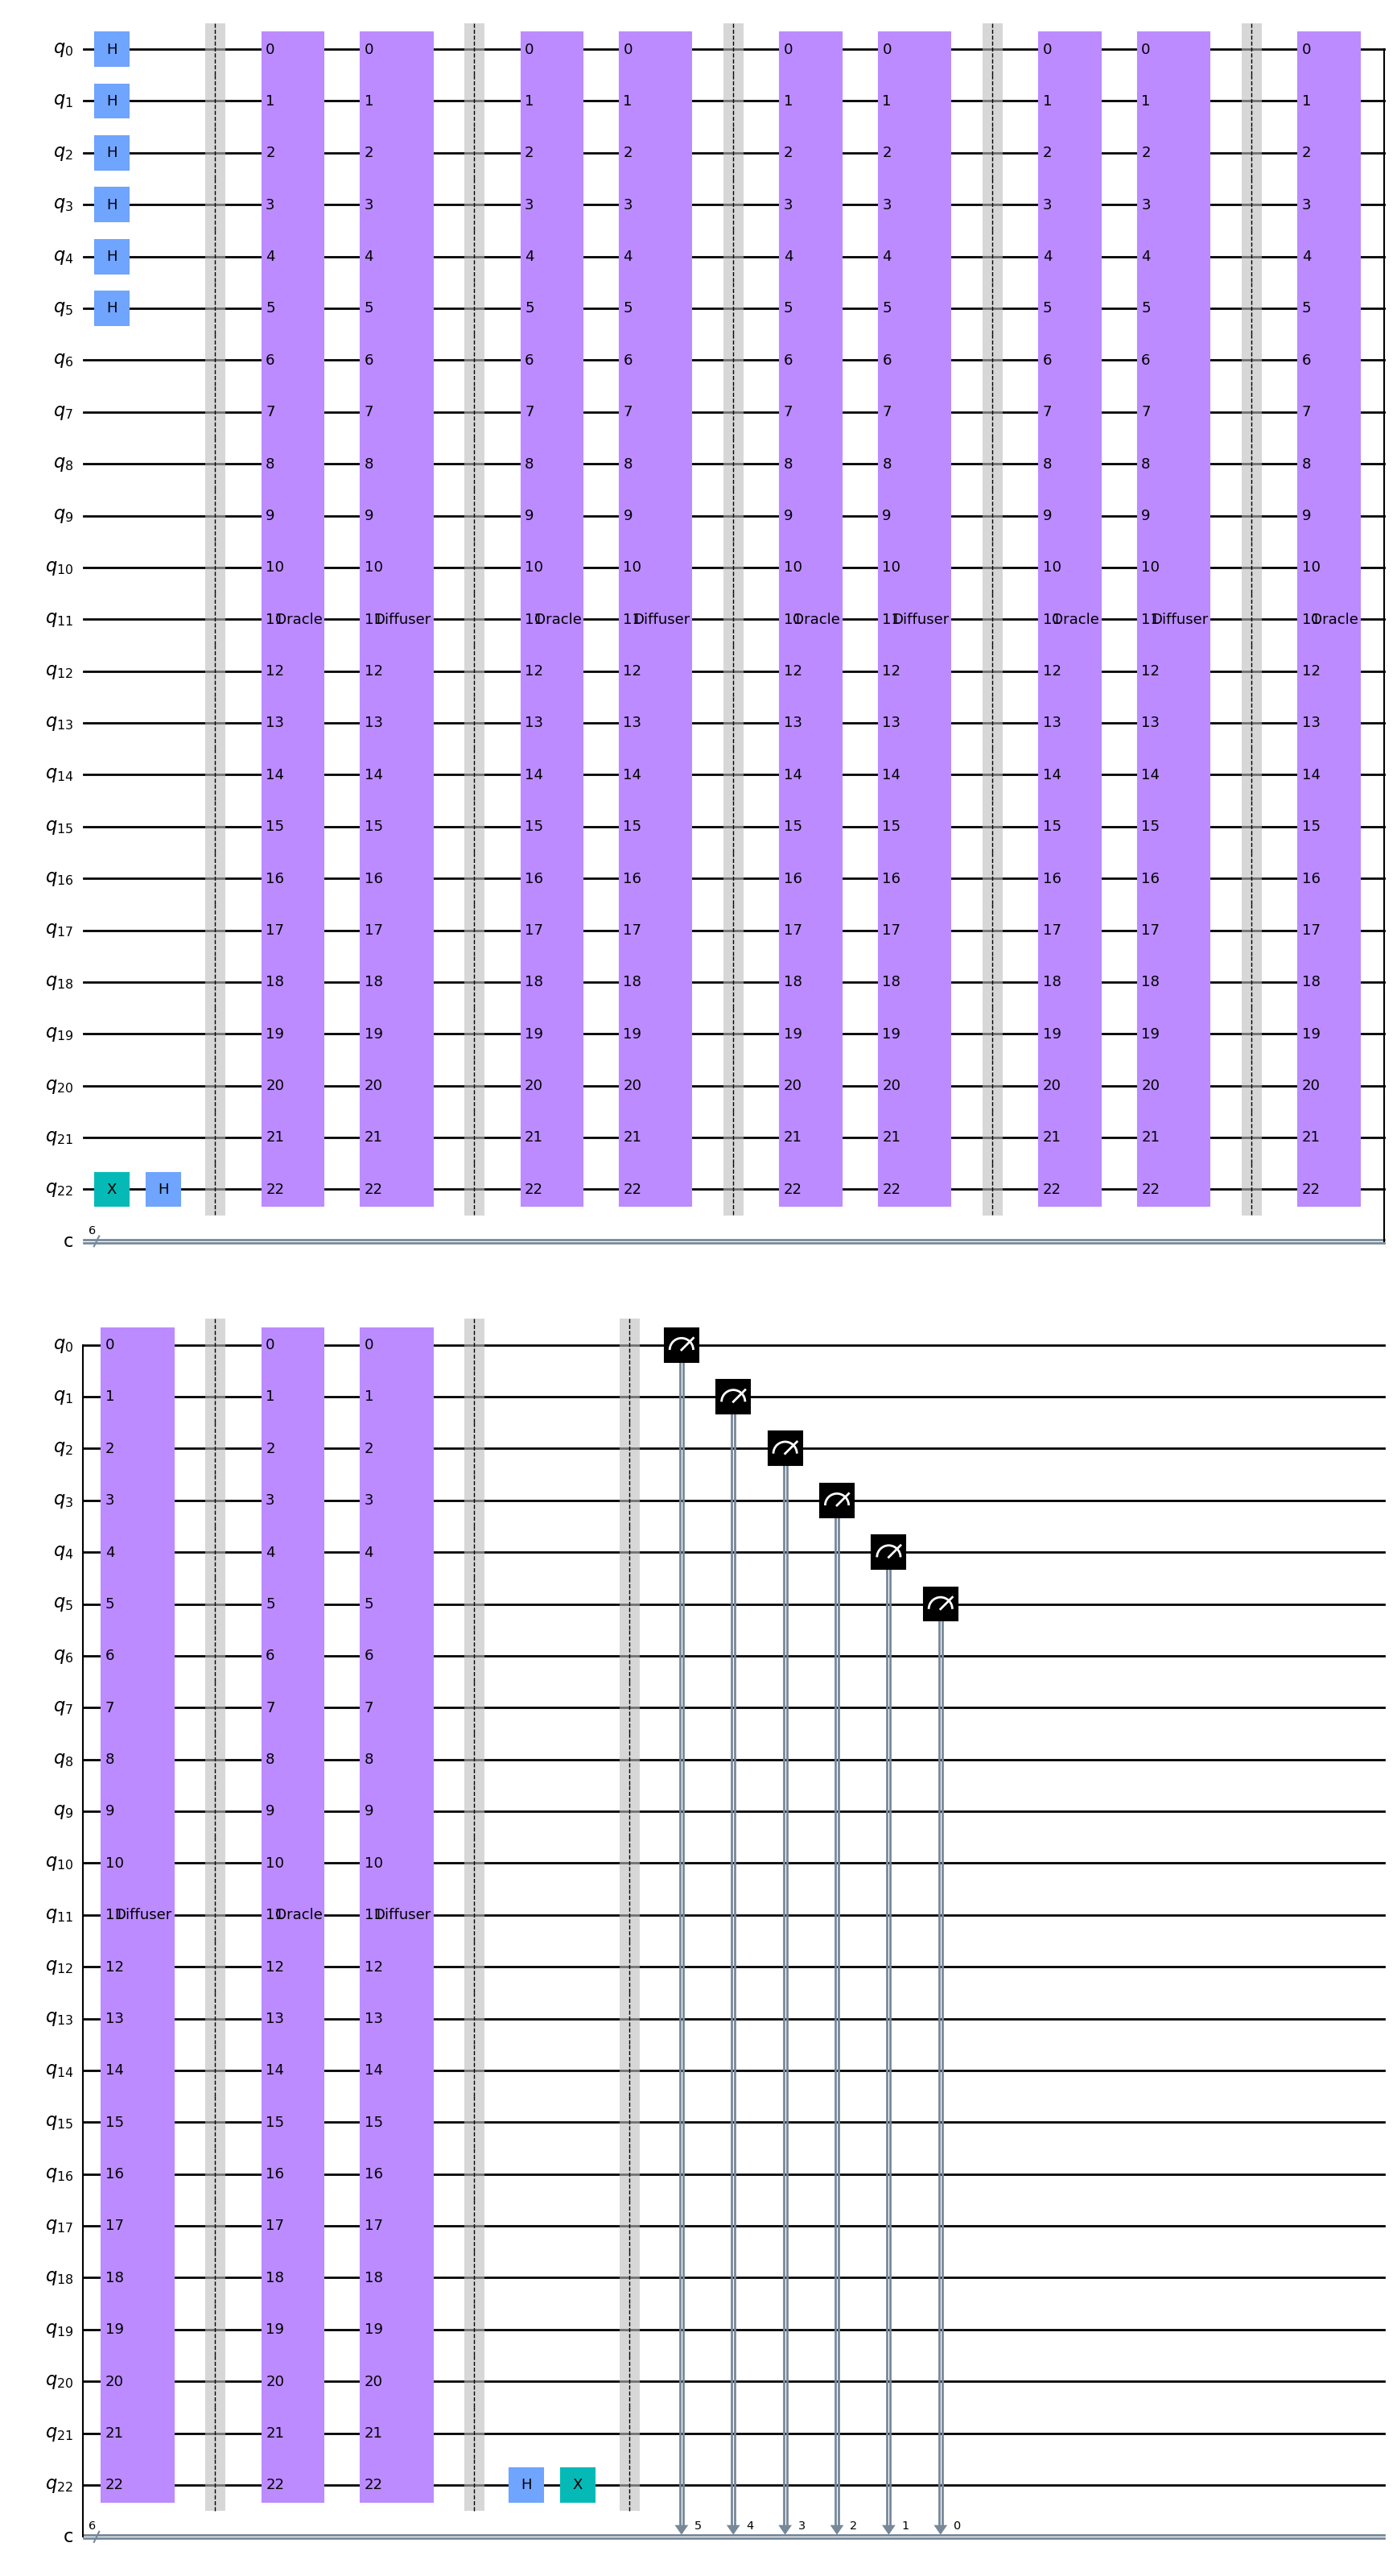

In [8]:
# ----- Create Circuit -----

oracle_gate = oracle.to_instruction()
diffuser_gate = diffuser.to_instruction()

qc = QuantumCircuit(NUM_QUBITS, NUM_VERTICES)

for i in range(0, NUM_VERTICES):
    qc.h(i)
    
qc.x(NUM_VERTICES + NUM_EDGES + SUM_QUBITS)
qc.h(NUM_VERTICES + NUM_EDGES + SUM_QUBITS)

qc.barrier()

for _ in range(0, GROVER_ITERATIONS):
    qc.append(oracle_gate, range(0, NUM_QUBITS))
    qc.append(diffuser_gate, range(0, NUM_QUBITS))
    qc.barrier()

qc.h(NUM_VERTICES + NUM_EDGES + SUM_QUBITS)
qc.x(NUM_VERTICES + NUM_EDGES + SUM_QUBITS)

qc.barrier()

for i in range(0, NUM_VERTICES):
    qc.measure(i, NUM_VERTICES - 1 - i)

qc.draw(output='mpl', style='iqp')

## Results

In [9]:
# Transpile circuit for backend
pass_manager = PassManager()
pass_manager.append(RemoveBarriers())
transpiled_qc = pass_manager.run(qc)
transpiled_qc = transpile(transpiled_qc, backend=backend, optimization_level=3)

# Run the circuit on backend
job = backend.run(transpiled_qc)

# Get the results
result = job.result()
counts = result.get_counts(transpiled_qc)

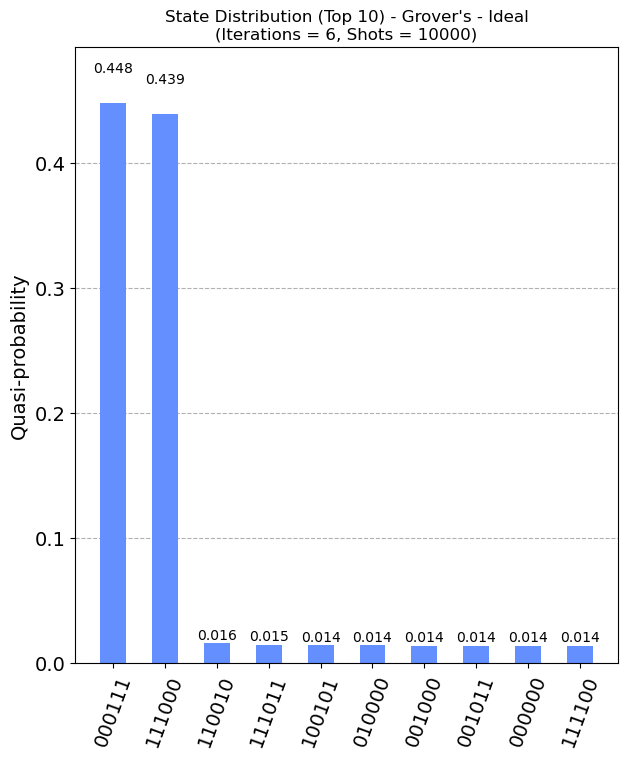

In [10]:
# Visualize simplified results
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - Grover's - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(Iterations = {GROVER_ITERATIONS}, Shots = {SHOTS})", filename=f"distribution-grover-{'noisy' if NOISY_SIMULATOR else 'ideal'}.pgf")
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - Grover's - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(Iterations = {GROVER_ITERATIONS}, Shots = {SHOTS})")

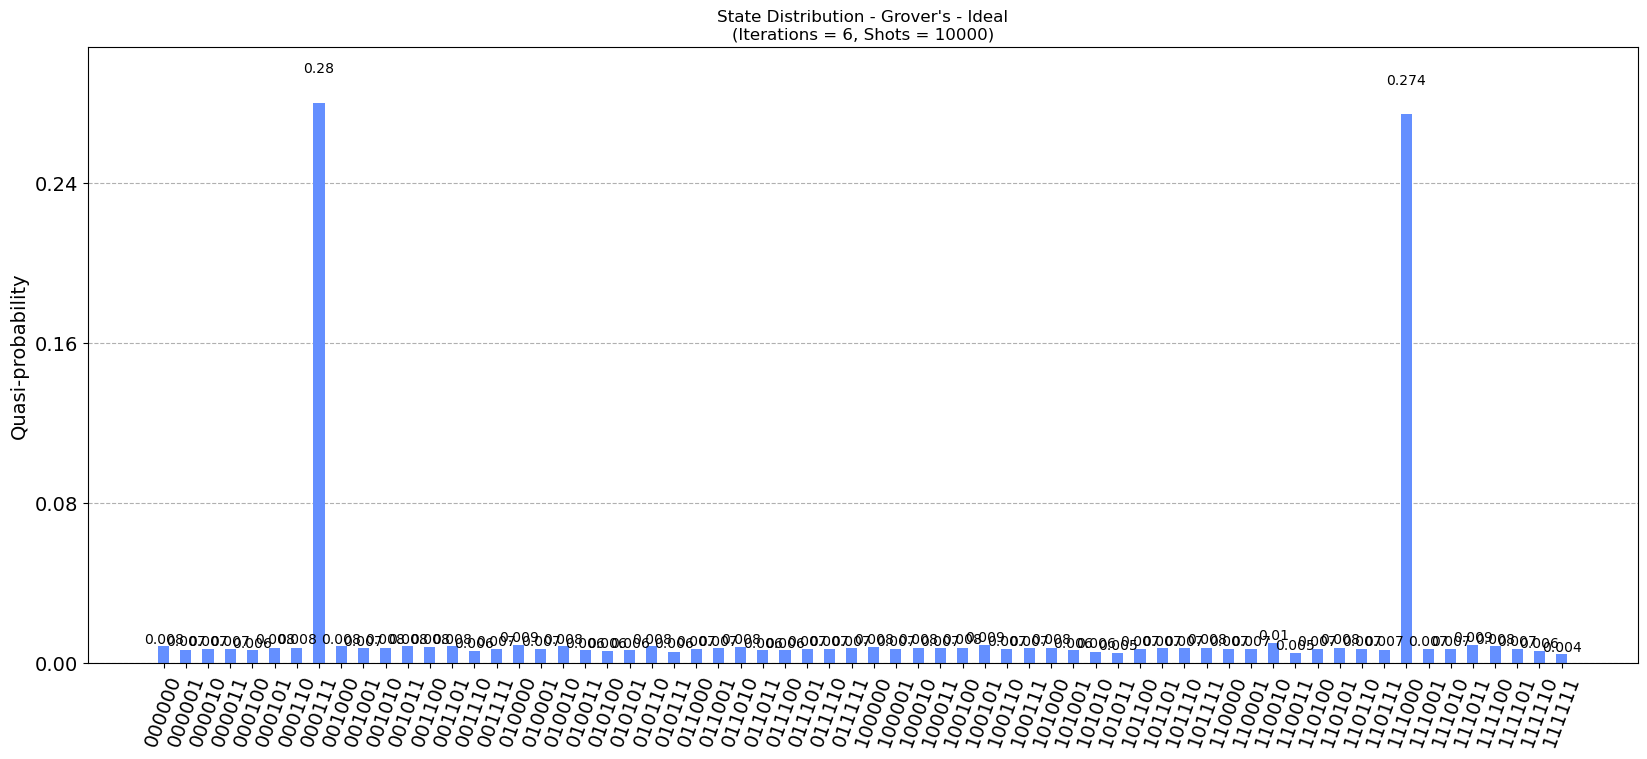

In [11]:
# Visualize full results
plot_distribution(counts, figsize=(20, 8), title=f"State Distribution - Grover's - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(Iterations = {GROVER_ITERATIONS}, Shots = {SHOTS})", filename=f"full-distribution-grover-{'noisy' if NOISY_SIMULATOR else 'ideal'}.pgf")
plot_distribution(counts, figsize=(20, 8), title=f"State Distribution - Grover's - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(Iterations = {GROVER_ITERATIONS}, Shots = {SHOTS})")

PARTITIONS:
	V1: {0, 1, 2}
	V2: {3, 4, 5}


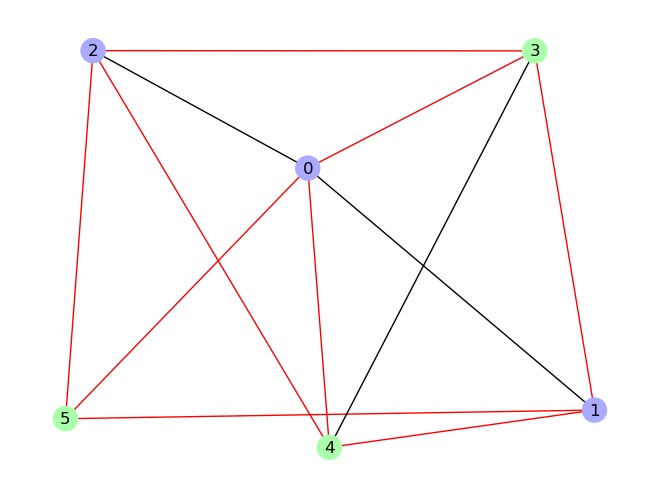

In [12]:
# Helper function that sums equivalent states
def calc_count(bitstring):
    count = counts.get(bitstring)
    count_flipped = counts.get(''.join(['1' if i == '0' else '0' for i in bitstring]))
    if count_flipped is None:
        count_flipped = 0
    return count + count_flipped

# Create partitions
Y = [int(i) if int(i) == 1 else -1 for i in max(counts, key=calc_count)]
V_1 = set([v for v in V if Y[v] == -1])
V_2 = set([v for v in V if Y[v] == 1])

# Print vertex subsets
print("PARTITIONS:")
print(f"\tV1: {V_1}")
print(f"\tV2: {V_2}")

# Visualize result graph
mpl_draw(
    G_draw,
    with_labels=True,
    node_color=["#aaffaa" if kk == 1 else "#aaaaff" for kk in Y],
    edge_color=["#ff0000" if (i in V_1 and j in V_2) or (i in V_2 and j in V_1) else "#000000" for (i, j) in E] 
)

## References

We referenced the following sources for our implementation.

1. [https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm)
2. [https://youtu.be/0RPFWZj7Jm0?si=0IwAd89HRpLL58OQ](https://youtu.be/0RPFWZj7Jm0?si=0IwAd89HRpLL58OQ)
3. [https://docs.quantum.ibm.com/](https://docs.quantum.ibm.com/)
4. [https://learning.quantum.ibm.com/course/variational-algorithm-design](https://learning.quantum.ibm.com/course/variational-algorithm-design)

We additionally utilized ChatGPT as a resource for learning and clarification during our implementation.